# Chapter 12 - Implementing a Multi-layer Artificial Neural Network from Scratch

In [7]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels

In [8]:
import sys

if sys.platform == 'win32':
    path = r'D:\Reference\书籍_Python\机器学习\python-machine-learning-book-3rd-edition-master\ch12'
else:
    path = '/Users/wangrui/Desktop/python-machine-learning-book-3rd-edition-master/ch12'

X_train, y_train = load_mnist(path, kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [9]:
784 ** 0.5

28.0

In [10]:
X_test, y_test = load_mnist(path, kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [11]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Visualize the first digit of each class

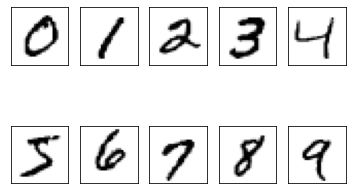

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True)
ax = ax.flatten() #仅仅将ax的索引展平，从而可以使用一维索引(否则使用二维索引)，但不影响画图位置
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

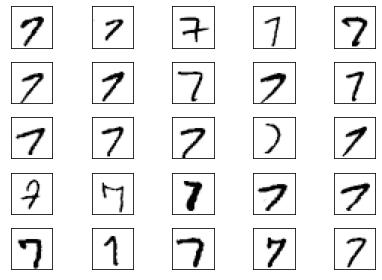

In [13]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
ax = ax.flatten() #仅仅将ax的索引展平，从而可以使用一维索引(否则使用二维索引)，但不影响画图位置
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

## Implementing a multi-layer perceptron

In [18]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0, epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
        
        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
        n_classes : int
            Number of classes

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hiden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_calsslabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = self.l2 * (np.sum(self.w_h ** 2) + np.sum(self.w_out ** 2))

        term1 = -y_enc * np.log(output)
        term2 = -(1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 + term2) + L2_term

        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)

        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        ----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns
        -------
        y_pred : array, shape = [n_examples]
            Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """Learn weights from training data.

        Parameters
        ----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features
        y_train : array, shape = [n_examples]
            Target class labels
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns
        -------
        self

        """
        n_output = np.unique(y_train).shape[0] # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0, scale=0.1, size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0, scale=0.1, size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs)) # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx: start_idx + self.minibatch_size]

                # forward propagation
                X = X_train[batch_idx]
                z_h, a_h, z_out, a_out = self._forward(X)

                ##################
                # Backpropagation
                ##################

                # Part 1: dLoss/dOutWeights
                ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
                ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
                ## for convenient re-use

                # input/output dim: [n_examples, n_classes]
                d_loss__d_a_out = a_out - y_train_enc[batch_idx]

                # input/output dim: [n_examples, n_classes]
                d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

                # output dim: [n_examples, n_classes]
                delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

                # gradient for output weights

                # [n_examples, n_hidden]
                d_z_out__dw_out = a_h

                # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
                # output dim: [n_classes, n_hidden]
                d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
                d_loss__db_out = np.sum(delta_out, axis=0)


                #################################
                # Part 2: dLoss/dHiddenWeights
                ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

                # [n_classes, n_hidden]
                d_z_out__a_h = self.w_out.T

                # input dim: [n_examples, n_classes] dot [n_classes, n_hidden]
                # output dim: [n_examples, n_hidden]
                d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

                # [n_examples, n_hidden]
                d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

                # [n_examples, n_features]
                d_z_h__d_w_h = X

                # input dim: [n_hidden, n_examples] dot [n_examples, n_features]
                # output dim: [n_hidden, n_features]
                d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
                d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0) # [n_hidden,]

                # Regularization and weight updates
                delta_w_h = d_loss__d_w_h.T + self.l2 * self.w_h
                delta_b_h = d_loss__d_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = d_loss__dw_out.T + self.l2 * self.w_out
                delta_b_out = d_loss__db_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)

            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            print('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            # sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self


In [23]:
n_epochs = 200

nn = NeuralNetMLP(n_hidden=100,
                  l2=0.01,
                  epochs=n_epochs,
                  eta=0.0005,
                  minibatch_size=100,
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

001/200 | Cost: 156947.64 | Train/Valid Acc.: 52.99%/55.88% 
002/200 | Cost: 127020.56 | Train/Valid Acc.: 70.10%/74.00% 
003/200 | Cost: 105011.84 | Train/Valid Acc.: 77.48%/81.64% 
004/200 | Cost: 90867.30 | Train/Valid Acc.: 80.97%/85.52% 
005/200 | Cost: 81419.93 | Train/Valid Acc.: 83.61%/87.98% 
006/200 | Cost: 74112.49 | Train/Valid Acc.: 84.85%/88.90% 
007/200 | Cost: 68581.19 | Train/Valid Acc.: 85.94%/89.88% 
008/200 | Cost: 64392.75 | Train/Valid Acc.: 86.83%/90.58% 
009/200 | Cost: 60682.80 | Train/Valid Acc.: 87.37%/90.82% 
010/200 | Cost: 57853.00 | Train/Valid Acc.: 87.79%/91.32% 
011/200 | Cost: 55440.44 | Train/Valid Acc.: 88.23%/91.58% 
012/200 | Cost: 53548.72 | Train/Valid Acc.: 88.67%/91.94% 
013/200 | Cost: 51475.40 | Train/Valid Acc.: 88.85%/92.08% 
014/200 | Cost: 50007.65 | Train/Valid Acc.: 89.16%/92.36% 
015/200 | Cost: 48707.77 | Train/Valid Acc.: 89.37%/92.54% 
016/200 | Cost: 47402.56 | Train/Valid Acc.: 89.54%/92.64% 
017/200 | Cost: 46348.06 | Train/Vali

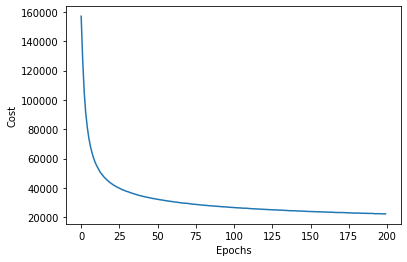

In [24]:
import matplotlib.pyplot as plt


plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

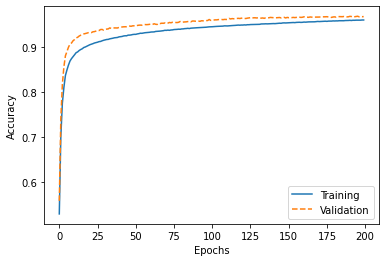

In [25]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'],
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
# plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [26]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 95.55%


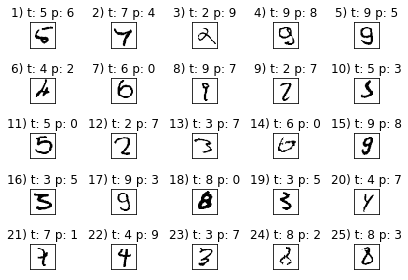

In [27]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('images/12_09.png', dpi=300)
plt.show()